In [1]:
!pip install EMD-signal
!pip install vnstock

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.9 MB/s eta 0:00:00
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.66.1
    Uninstalling tqdm-4.66.1:
      Successfully uninstalled tqdm-4.66.1


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import PyEMD as pe
from vnstock import *

Observations:  1629
            Open  High   Low  Close   Volume Ticker
Time                                               
2017-06-02  3230  3330  3200   3280   411631    VND
2017-06-05  3320  3370  3270   3280   671582    VND
2017-06-06  3280  3320  3270   3320   174560    VND
2017-06-07  3320  3610  3320   3590  2332950    VND
2017-06-08  3640  3640  3510   3540   467477    VND
2017-06-09  3520  3660  3520   3560   726174    VND


<Axes: xlabel='Time'>

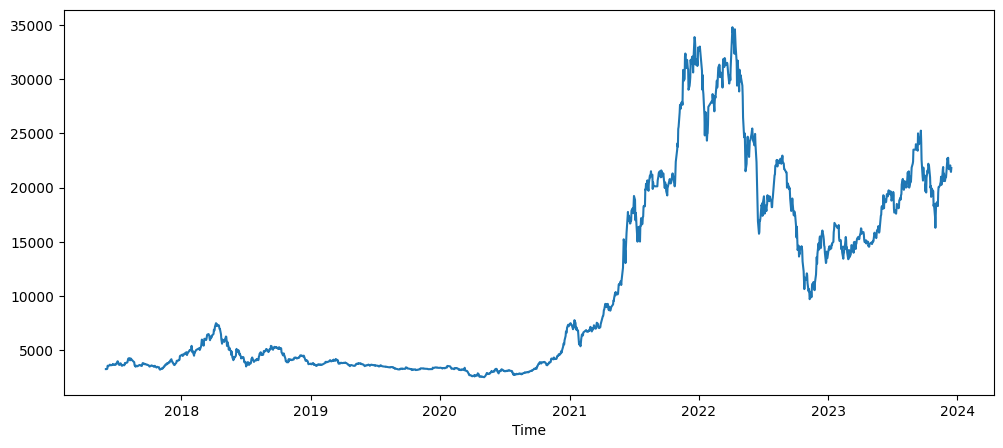

In [3]:
# Import data
VND = stock_historical_data(symbol = "VND", start_date="2017-06-01", end_date="2023-12-15", resolution="1D", type = "stock", beautify=True, decor=True, source = "DNSE")
from matplotlib import pyplot
print("Observations: ",len(VND['Close']))
print(pd.DataFrame(VND.head(6)))
train_dates = VND.index
plt.figure(figsize=(12, 5))
VND["Close"].plot()

In [4]:
VND = VND.reset_index(drop = True)
df = VND['Close']
df

0        3280
1        3280
2        3320
3        3590
4        3540
        ...  
1624    21950
1625    22050
1626    21600
1627    21450
1628    21800
Name: Close, Length: 1629, dtype: int64

In [5]:
## (A) CEEMDAN
#### 1. Thêm white noise vào chuỗi gốc s(t) thành chuỗi s1(t)
#### 2. Decompose chuỗi s1(t) bằng EMD ra các chuỗi IMF1 và Residue1
#### 3. Trung bình các chuỗi IMF1(t) thành mIMF1(t)
#### 4. r1(t) = s1(t) - mIMF1(t)
#### 5. Chuỗi mới s2(t) = r1(t) + coef*EMD(noise)
#### 6. Làm lại từ 1->5 đến khi chuỗi residue dừng

In [6]:
from PyEMD import EMD, CEEMDAN

In [7]:
ceemdan = CEEMDAN(range_thr=0.001, total_power_thr=0.01)
cIMFs = ceemdan.ceemdan(S=np.array(df.values), T= np.array(df.index))

In [8]:
pd.DataFrame(cIMFs.T, columns = ["IMF"+str(i+1) for i in range(cIMFs.shape[0])])

,IMF1,IMF2,IMF3,IMF4,IMF5,IMF6,IMF7
0,-41.771149,-58.708577,-65.040775,-75.656268,54.969380,-641.985997,4108.193386
1,-19.784955,-77.188874,-72.881909,-76.134159,70.506597,-649.779323,4105.262624
2,-65.462195,-21.723633,-53.537148,-71.030411,86.705486,-657.294859,4102.342760
3,86.039634,44.411124,-17.658486,-61.218065,103.520264,-664.528252,4099.433781
4,-30.178309,51.297490,20.782925,-47.863905,120.901277,-671.475151,4096.535672
...,...,...,...,...,...,...,...
1624,158.688291,-407.888843,-99.612479,3036.423182,-1743.439090,3722.077708,17283.751231
1625,279.283347,-315.418663,-265.220869,3100.864882,-1718.735699,3686.634150,17282.592852
1626,-156.075289,-264.782732,-363.962418,3143.657192,-1690.815732,3650.446985,17281.531994
1627,-314.154605,-246.850567,-386.526221,3163.110731,-1659.668442,3613.520724,17280.568380


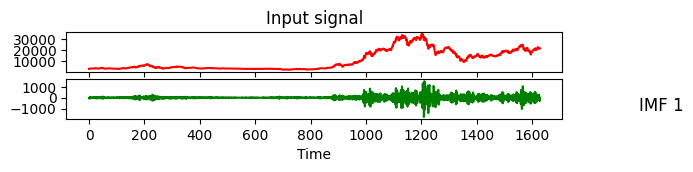

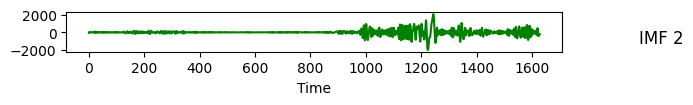

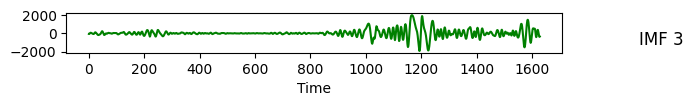

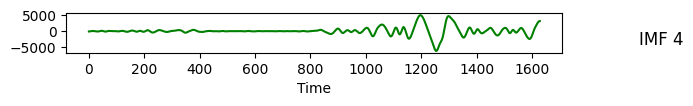

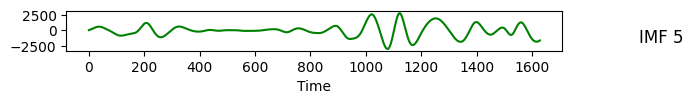

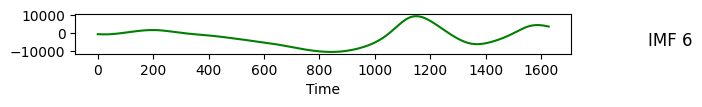

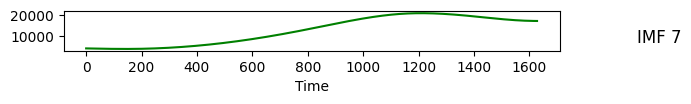

In [9]:
N = cIMFs.shape[0]+1
# Plot results
plt.subplot(N,1,1)
plt.plot(df.index, df.values, 'r')
plt.title("Input signal")
plt.xlabel("Time")

for n, imf in enumerate(cIMFs):
  plt.subplot(N,1,n+2)
  plt.plot(df.index, imf, 'g')
  plt.title("IMF "+str(n+1), x=1.2, y = 0)
  plt.xlabel("Time")
  plt.show()

In [10]:
# Tính residue
scIMF = cIMFs.sum(axis = 0).reshape(-1, 1)
residue = (np.array(df)-cIMFs.sum(axis = 0)).reshape(-1,1)

print("sIMF:", scIMF.shape)
print("Residue:", residue.shape)

sIMF: (1629, 1)
Residue: (1629, 1)


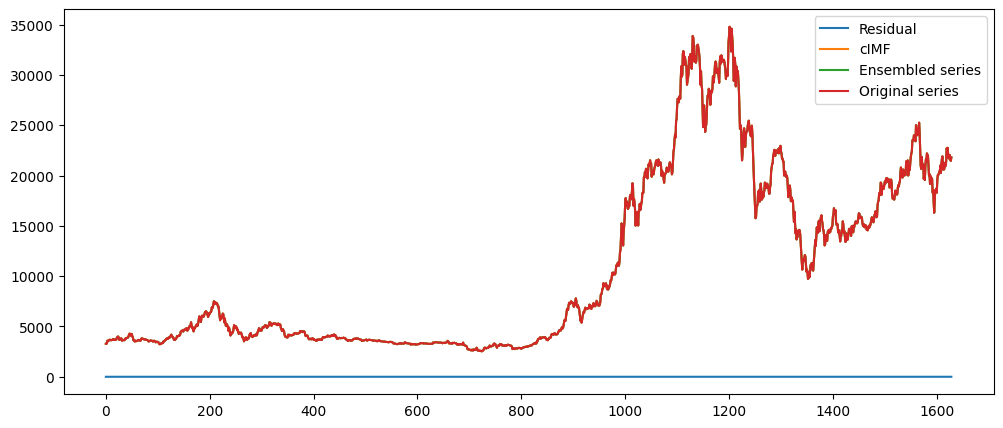

In [11]:
plt.figure(figsize=(12,5))
plt.plot(range(0,len(df)), residue)
plt.plot(range(0,len(df)), scIMF)
plt.plot(range(0,len(df)), scIMF+residue)
plt.plot(df)
plt.legend(["Residual", "cIMF", "Ensembled series", "Original series"])

plt.show()

In [12]:
# (B) LSTM
## 0. Prepocessing
# load các thư viện cần thiết
import math
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_predict, train_test_split,GridSearchCV,cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder,StandardScaler,PowerTransformer, MinMaxScaler, RobustScaler

In [13]:
cIMF = cIMFs.sum(axis = 0).reshape(-1, 1)+residue
cIMF

array([[ 3280.],
       [ 3280.],
       [ 3320.],
       ...,
       [21600.],
       [21450.],
       [21800.]])

In [14]:
# Scale data to 0-1
scaler = StandardScaler()
def Scaling (data):
    IMFscale = scaler.fit_transform(np.array(data))

    return IMFscale
IMFscale = Scaling(cIMF)
#train_scaled = scaler.inverse_transform(train_scaled)
#pd.DataFrame(train_scaled, columns=["IMF"+str(i+1) for i in range(cIMFs.shape[0])])

(1629, 1)
Train:  (1303, 1)
Test:  (326, 1)


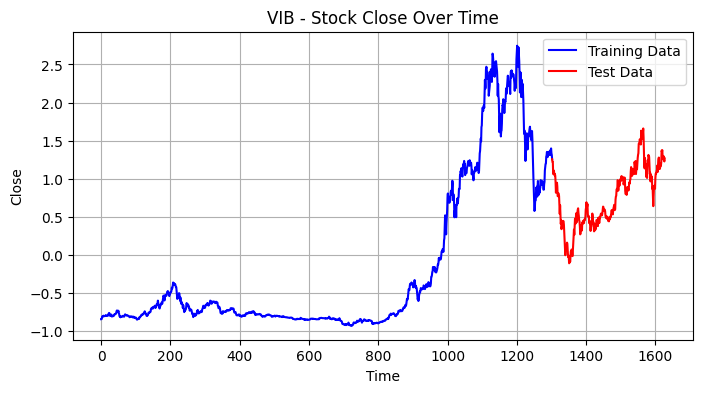

In [15]:
print(IMFscale.shape)
# Chia train test
train_size = int(0.8*IMFscale.shape[0])
test_size = int(0.2*IMFscale.shape[0])
train_data = IMFscale[:train_size].reshape(-1,1)
test_data = IMFscale[train_size:].reshape(-1,1)

print("Train: ", train_data.shape)
print("Test: ", test_data.shape)

# Plotting both training and test data on the same chart
plt.figure(figsize=(8, 4))

plt.plot(range(train_size), train_data, linestyle='-', color='b', label='Training Data')
plt.plot(range(train_size -1,  train_size+test_size), test_data, linestyle='-',  color='r', label='Test Data')


plt.title('VIB - Stock Close Over Time')
plt.xlabel('Time')
plt.ylabel('Close')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
trainX = []
trainY = []

n_past = 60
n_future = 1

for i in range(n_past, len(train_data) - n_future + 1):
    past_sequence = train_data[i - n_past:i, 0:train_data.shape[1]]  # Exclude the first column ("Close") for trainX
    future_sequence = train_data[i + n_future - 1: i + n_future, 0]  # Use the "Close" column for trainY

    trainX.append(past_sequence)
    trainY.append(future_sequence)

trainX, trainY = np.array(trainX), np.array(trainY)
print("X train: ", trainX.shape)
print("Y train: ", trainY.shape)

X train:  (1243, 60, 1)
Y train:  (1243, 1)


In [17]:
testX = []
testY = []

for i in range(n_past, len(test_data) - n_future + 1):
    past_sequence = test_data[i - n_past:i, 0:test_data.shape[1]]  # Exclude the first column ("Close") for trainX
    future_sequence = test_data[i + n_future - 1: i + n_future, 0]  # Use the "Close" column for trainY

    testX.append(past_sequence)
    testY.append(future_sequence)

testX, testY = np.array(testX), np.array(testY)

print("X test: ", testX.shape)
print("Y test: ", testY.shape)

X test:  (266, 60, 1)
Y test:  (266, 1)


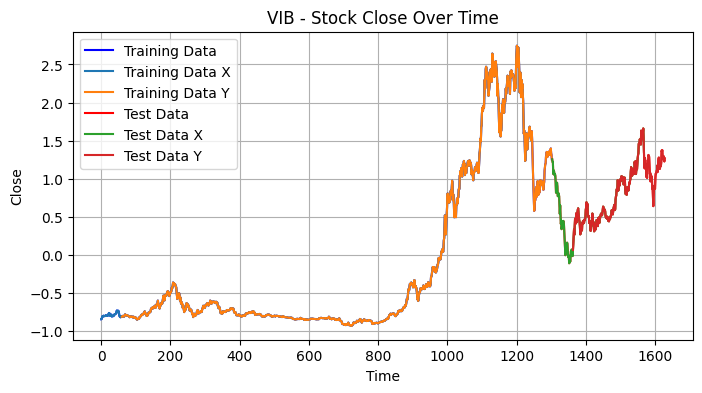

In [18]:
# Plotting both training and test data on the same chart
plt.figure(figsize=(8, 4))

plt.plot(range(train_size), train_data, linestyle='-', color='b', label='Training Data')
plt.plot(range(train_size-n_past), trainX[:,0,0], linestyle='-', label='Training Data X')
plt.plot(range(n_past,train_size), trainY[:,0], linestyle='-', label='Training Data Y')
plt.plot(range(train_size, train_size+test_size+1), test_data, linestyle='-',  color='r', label='Test Data')
plt.plot(range(train_size, train_size+test_size-n_past+1), testX[:,0,0], linestyle='-',  label='Test Data X')
plt.plot(range(train_size+n_past, train_size+test_size+1), testY[:,0], linestyle='-', label='Test Data Y')


plt.title('VIB - Stock Close Over Time')
plt.xlabel('Time')
plt.ylabel('Close')
plt.legend()

plt.show()

In [19]:
## 1. Train model
# Tạo model lstm cho việc training
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))
model.compile(optimizer='adam', loss='mape')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 64)            16896     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 29345 (114.63 KB)
Trainable params: 29345 (114.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
# fit the model
history = model.fit(trainX, trainY, epochs=60, batch_size=4, validation_split=0.1, verbose=1)

Epoch 1/60
280/280 [==============================] - 18s 49ms/step - loss: 29.9766 - val_loss: 19.2851
Epoch 2/60
280/280 [==============================] - 13s 48ms/step - loss: 21.9761 - val_loss: 14.3720
Epoch 3/60
280/280 [==============================] - 13s 48ms/step - loss: 20.0257 - val_loss: 13.4184
Epoch 4/60
280/280 [==============================] - 13s 48ms/step - loss: 20.7236 - val_loss: 18.8054
Epoch 5/60
280/280 [==============================] - 14s 50ms/step - loss: 17.3818 - val_loss: 21.6500
Epoch 6/60
280/280 [==============================] - 13s 48ms/step - loss: 17.9819 - val_loss: 12.0013
Epoch 7/60
280/280 [==============================] - 15s 55ms/step - loss: 16.6262 - val_loss: 14.9109
Epoch 8/60
280/280 [==============================] - 13s 48ms/step - loss: 18.1097 - val_loss: 12.7872
Epoch 9/60
280/280 [==============================] - 13s 48ms/step - loss: 18.1801 - val_loss: 12.8977
Epoch 10/60
280/280 [==============================] - 13s 48ms/

In [21]:
prediction = model.predict(testX)
prediction_copies = np.repeat(prediction, train_data.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]
print(y_pred_future)

9/9 [==============================] - 1s 16ms/step
[11517.269  11601.183  11912.676  12451.891  13177.783  13446.913
 13937.258  14675.6    14840.207  14904.989  15413.785  15786.142
 15436.978  15753.151  15976.275  16256.397  16467.334  16243.522
 15979.115  15572.788  15318.41   14941.417  14368.075  14064.68
 14216.09   14404.584  14278.47   14196.654  14537.919  14730.637
 14962.167  14940.6455 14967.494  14974.2    15145.071  15211.896
 15346.832  15464.654  16012.231  16424.434  16983.248  16920.977
 16862.293  17005.422  16396.379  15980.803  15772.401  15700.483
 15289.971  15198.839  15057.373  14812.417  14456.406  14435.122
 14477.79   14793.254  14912.677  15486.378  15629.528  15285.968
 15181.603  14888.856  14484.103  14262.673  14481.79   14475.972
 14352.946  14381.716  14557.192  14902.791  15102.622  15109.147
 15102.499  14863.005  15176.19   15273.156  15430.918  15191.484
 15277.186  15341.145  15532.114  15709.129  15877.774  15847.44
 15882.768  15839.185  159

In [22]:
train_back = scaler.inverse_transform(train_data)
test_back = scaler.inverse_transform(test_data)

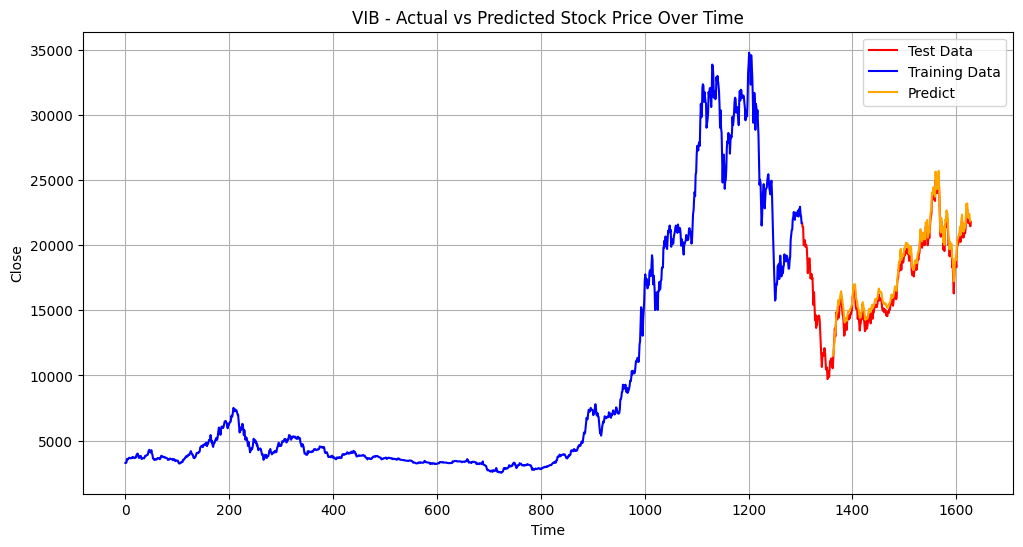

In [23]:
plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(range(train_size, train_size+test_size+1),test_back.reshape(-1,1), linestyle='-',  color='r', label='Test Data')
plt.plot(range(train_size), train_back, linestyle='-', color='b', label='Training Data')
#predict_date = Test_data['Time'];
plt.plot(range(train_size+n_past-1, train_size+test_size),  y_pred_future, label='Predict', linestyle='-',  color='orange')
# # Plot predicted values
#plt.plot( test_Date, y_pred, label='Predicted', linestyle='-',  color='b')

plt.title('VIB - Actual vs Predicted Stock Price Over Time')
plt.xlabel('Time')
plt.ylabel('Close')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
n_past = 1
n_days_for_prediction= 60

#print(test_data.reshape(1,-1).T.shape)

test_for_forecast = test_data.reshape(1,-1).T

x_forecast = []
y_forecast = []

for i in range(n_days_for_prediction):
  # B1 Duyệt dữ liệu test n ngày gần nhất => bỏ vào x tạm
  x = np.array(test_for_forecast[(-60):])
  print(x.shape)
  x = x.T.reshape(x.shape[1], x.shape[0], 1)
  print(x.shape)

  # B2 dùng predict để chạy 1 ngày
  y = model.predict(x)
  # B3 thêm data ngày đó vào y_forecast, test_for_forecast và append x vào x_forecast
  y_c = np.repeat(y, x.shape[1], axis=-1)
  y_pr = scaler.inverse_transform(y_c)[:,0]

  x_forecast.append(x)
  y_forecast.append(y_pr)
  test_for_forecast = np.append(test_for_forecast, y).reshape(-1,1)
  print(test_for_forecast.shape)
  #test_for_forecast.append(y)
  # B4 lặp lại đến ngày thứ 60

x_forecast = np.array(x_forecast)
y_forecast = np.array(y_forecast)

(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 28ms/step
(327, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 26ms/step
(328, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 36ms/step
(329, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 28ms/step
(330, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 28ms/step
(331, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 27ms/step
(332, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 29ms/step
(333, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 29ms/step
(334, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 34ms/step
(335, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 31ms/step
(336, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 28ms/step
(337, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 29ms/step
(338, 1)
(60, 1)
(1, 60, 1)
1/1 [================

In [25]:
print(y_forecast)

[[22168.049]
 [22560.057]
 [22984.572]
 [23434.53 ]
 [23902.95 ]
 [24384.393]
 [24874.871]
 [25370.23 ]
 [25866.879]
 [26361.496]
 [26850.914]
 [27332.041]
 [27804.822]
 [28270.762]
 [28729.832]
 [29181.361]
 [29624.309]
 [30057.395]
 [30479.232]
 [30888.4  ]
 [31283.523]
 [31663.328]
 [32026.695]
 [32372.68 ]
 [32700.537]
 [33009.73 ]
 [33299.95 ]
 [33571.086]
 [33823.242]
 [34056.7  ]
 [34271.914]
 [34469.477]
 [34650.105]
 [34814.613]
 [34963.887]
 [35098.855]
 [35220.48 ]
 [35329.734]
 [35427.57 ]
 [35514.934]
 [35592.73 ]
 [35661.832]
 [35723.06 ]
 [35777.184]
 [35824.92 ]
 [35866.94 ]
 [35903.85 ]
 [35936.21 ]
 [35964.54 ]
 [35989.29 ]
 [36010.88 ]
 [36029.68 ]
 [36046.027]
 [36060.23 ]
 [36072.55 ]
 [36083.21 ]
 [36092.434]
 [36100.402]
 [36107.277]
 [36113.203]]


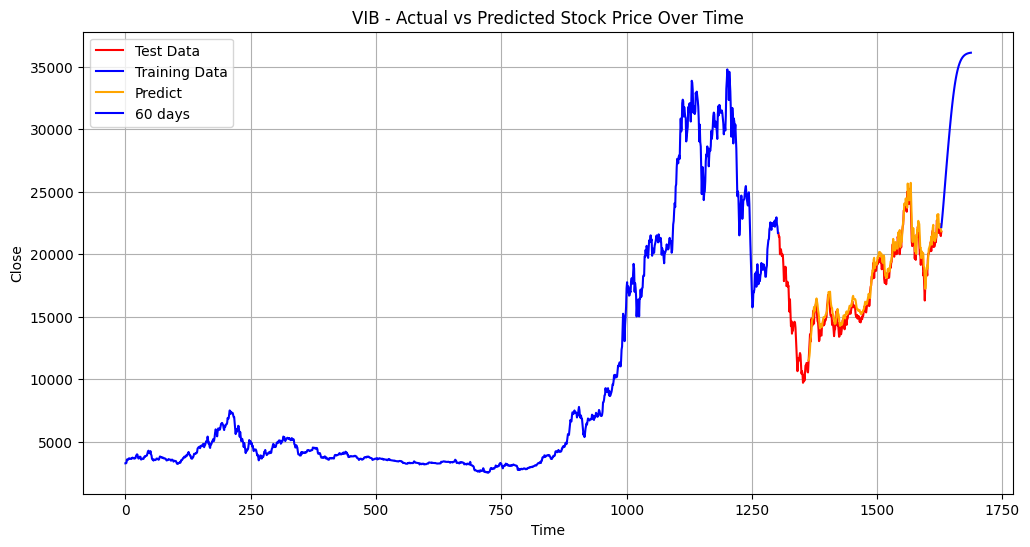

In [26]:
plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(range(train_size, train_size+test_size+1),test_back.reshape(-1,1), linestyle='-',  color='r', label='Test Data')
plt.plot(range(train_size), train_back, linestyle='-', color='b', label='Training Data')
# Plot predict test and actual test
plt.plot(range(train_size + 60, train_size + test_size+1),  y_pred_future, label='Predict', linestyle='-',  color='orange')
# Plot 60 days
plt.plot(range(train_size+test_size, train_size+test_size+60), y_forecast, linestyle='-', color='b', label='60 days')

plt.title('VIB - Actual vs Predicted Stock Price Over Time')
plt.xlabel('Time')
plt.ylabel('Close')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
def RSME (data1, data2):
    return np.sqrt(np.mean((data1-data2)*(data1-data2)))
def MAE (data1, data2):
    return np.mean(np.absolute(data1-data2))
def MAPE (pred, actual):
    return np.mean(np.absolute((pred-actual)/actual))*100

In [28]:
print("RSME: ", RSME(y_pred_future, test_back[-60:]))
print("MAE: ", MAE(y_pred_future, test_back[-60:]))
print("MAPE: ", MAPE(y_pred_future, test_back[-60:]))

RSME:  4099.257347491573
MAE:  3404.1951625890897
MAPE:  16.514470120611012


In [29]:
def MSLE (pred, actual):
    return np.mean((np.log(1+actual)-np.log(1+pred))*(np.log(1+actual)-np.log(1+pred)))
print("MSLR: ", MSLE(y_pred_future, test_back[14:]))

MSLR:  0.07761789200395317
